In [134]:
import ROOT, rat
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline 
sys.path.append('/home/jp/projects/python_tools')
sys.path.append('/home/jp/projects/snoplus/python_modules')
import jp_mpl as jplot
from jp_analysis import *
from greydisc_functions import *
import rat
from itertools import cycle
from scipy.stats import truncnorm
plt.rcParams['image.cmap'] = 'YlOrRd'

###  Start here if you have already loaded/selected the tracks

In [135]:
data = pickle.load(open('/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_geo/condensed_337nm.pckl'))


In [136]:
# The momentum is not a unit vector. Don't know why. Renormalizing it
momentum_norm = np.linalg.norm(data['momentum'],axis=1)
momentum_norm = momentum_norm.reshape(momentum_norm.size, 1)
data['momentum'] /= momentum_norm
my_times = np.zeros_like(data['r'])
my_z     = np.zeros_like(my_times)
for ievent in range(len(data['r'])):
    x0 = data['x'][ievent]
    y0 = data['y'][ievent]
    z0 = 130.4

    u = data['momentum'][ievent,0]
    v = data['momentum'][ievent,1]
    w = data['momentum'][ievent,2]
    t = pmtContactTime(x0,y0,z0, u,v,w)
    z = pmtContactDepth(z0, w, t)
    my_times[ievent] = t
    my_z[ievent] = z

In [137]:
pmt_hits = (my_z < 100)
conc_hits = (my_z > 100)

print 'PMT hits', np.sum(pmt_hits)
print 'Concentrator hits', np.sum(conc_hits)


PMT hits 20155
Concentrator hits 186905


In [138]:
data['nsteps'] = np.ceil(data['nsteps']/7)-1

# PMT Hit first

In [139]:
sel=( np.array([True]*len(data['y']))
     *pmt_hits
     #*(data['r']>0)
    )

### Estimating the number of reflections 

Trying to obtain an estimator of the number of steps for the HIT PMT photons


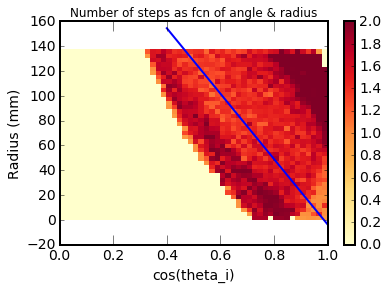

In [140]:
print 'Trying to obtain an estimator of the number of steps for the HIT PMT photons'
xvalues = np.cos(data['theta_i'][sel])
yvalues = data['r'][sel]

x = np.linspace(0, 1., 51)
y = np.linspace(0, greydisc_radius, 41)

b,x1,y1 = np.histogram2d(xvalues, yvalues, [x,y],
                       weights=data['nsteps'][sel])
b2,x1,y1 = np.histogram2d(xvalues, yvalues, [x,y])

plt.pcolor(x,y,(b/(b2+0.1)).T, vmin=0, vmax=2)


plt.colorbar()

myx = np.linspace(0.4, 1.0, 101)
plt.plot(myx, line_fcn(myx,-145/(0.95-0.4), 260.))

plt.xlabel('cos(theta_i)')
plt.ylabel('Radius (mm)')
plt.title('Number of steps as fcn of angle & radius')

1.56686777558


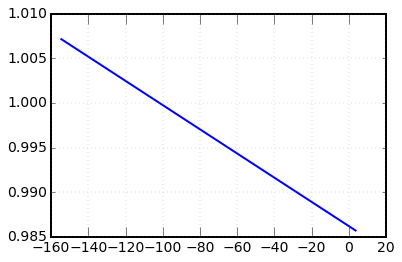

In [141]:
# Rotating the line
y_data = line_fcn(myx, -145/(0.95-0.4), 260.)
x_data = myx
rotation = np.arctan(140/0.55)
print rotation
xpp = x_data*np.cos(rotation) - y_data*np.sin(rotation)
ypp = x_data*np.sin(rotation) + y_data*np.cos(rotation)
#plt.plot(x_data, y_data)
plt.plot(xpp,ypp)


Rotating, removing one of the parameters, everything as function of theta_i
1.56686777558 89.7749105956


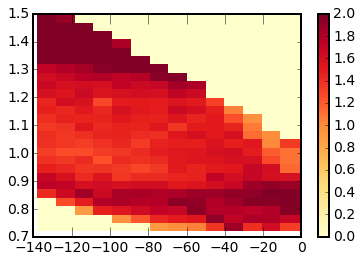

In [142]:
print 'Rotating, removing one of the parameters, everything as function of theta_i'

rotation_angle = np.arctan(140/0.55)
print rotation_angle, np.rad2deg(rotation_angle)


xprime = xvalues*np.cos(rotation_angle) - yvalues*np.sin(rotation_angle)
yprime = xvalues*np.sin(rotation_angle) + yvalues*np.cos(rotation_angle)

x = np.linspace(xprime.min(), xprime.max(), 15)
y = np.linspace(yprime.min(), yprime.max(), 27)

b,x1,y1 = np.histogram2d(xprime, yprime, [x,y],
                       weights=data['nsteps'][sel])
b2,x1,y1 = np.histogram2d(xprime, yprime, [x,y])
plt.figure()
mydata = (b/(b2+0.1)).T

plt.pcolor(x,y, mydata, vmin=0, vmax=2)
plt.colorbar()
xindex = np.where(x>-70)[0][0]
#plt.axvline(x[xindex], 0, 1.6)




Verification


/home/jp/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


The rotation is given by
value = np.cos(data['theta_i'][sel])*np.sin(rot_angle) + data['r'][sel]*np.cos(rot_angle)
The rotation angle is 1.56686777558
The rotated values is used to evaluate this function
       2
-7.92 x + 16.88 x - 8.37
Draw a random value. If the value is higher than the function, multiple reflection


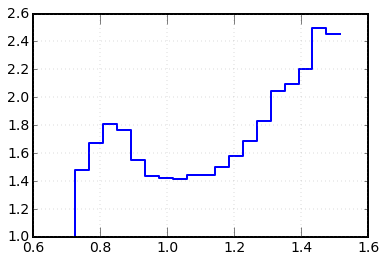

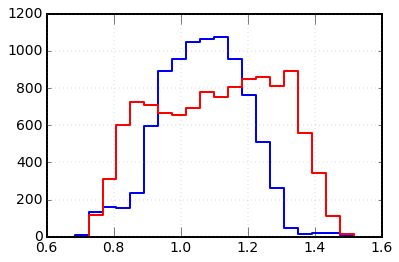

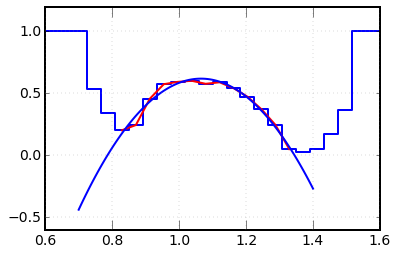

In [143]:
print 'Verification'
rot_angle = 1.56686777558#1.56686777558#1.56686777558
xp = np.cos(data['theta_i'][sel])*np.sin(rot_angle) + data['r'][sel]*np.cos(rot_angle)

xaxis = np.linspace(0.6, 1.6, 25)
xeval = np.linspace(0.6, 1.6, 201)

plt.figure()
n,x = np.histogram(xp, xaxis, weights = data['nsteps'][sel])
n2,x = np.histogram(xp, xaxis)
jplot.unfilledBar(x,n/n2)

plt.figure()
single = (data['nsteps'][sel] < 1.5)
n, x = np.histogram(xp[single], xaxis)
n2, x = np.histogram(xp[~single], xaxis)

jplot.unfilledBar(x,n, color = 'blue')
jplot.unfilledBar(x,n2, color = 'red')

plt.figure()

ratio = (n+0.01)/(n2+n+0.01)
jplot.unfilledBar(x, ratio)

xfit = (x[:-1]+x[1:])/2.
indices = [np.where(xfit>0.8)[0][0], np.where(xfit<1.4)[0][-1]]
plt.plot(xfit[indices[0]:indices[1]], ratio[indices[0]:indices[1]], '-r')

fcn = np.poly1d(np.polyfit(xfit[indices[0]:indices[1]], ratio[indices[0]:indices[1]], deg=2))
test_x = np.linspace(0.7, 1.4, 101)

plt.plot(test_x, fcn(test_x))
print "The rotation is given by\nvalue = np.cos(data['theta_i'][sel])*np.sin(rot_angle) + data['r'][sel]*np.cos(rot_angle)"
print "The rotation angle is", rot_angle
print "The rotated values is used to evaluate this function"
print fcn
print "Draw a random value. If the value is higher than the function, multiple reflection"

### Theta angle for single reflections

In [144]:
print 'Selecting only the events that hit the PMT and leave in a single reflection'
sel=( np.array([True]*len(data['y']))
     *pmt_hits
     *(data['nsteps'] < 2)
     #*(data['z'] > 0)
     #*(data['r']>80)
    )


Selecting only the events that hit the PMT and leave in a single reflection


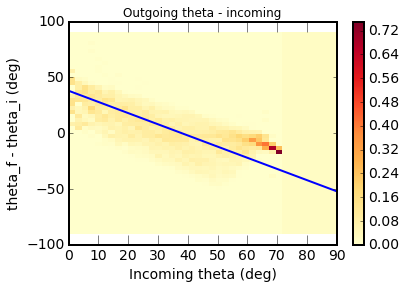

In [145]:
x1 = np.linspace(0, np.pi/2., 41)
x2 = np.linspace(-np.pi/2, np.pi/2., 51)
n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                           data['theta_f'][sel] - data['theta_i'][sel], 
                           [x1,x2])
n = renormN(n,axis=1)
plt.pcolor(np.rad2deg(x1),
           np.rad2deg(x2),
           n.T)
plt.xlabel('Incoming theta (deg)')
plt.ylabel('theta_f - theta_i (deg)')
plt.colorbar()
plt.title('Outgoing theta - incoming')
#plt.yticks(np.arange(-90, 90, 5.0))

xaxis_line = np.linspace(0, 90, 201)
yvalues = line_fcn(xaxis_line, -40./40, 38)
plt.plot(xaxis_line, yvalues)

The distribution has been rotated (delta Theta and theta in are the inputs)
The rotation is given by
new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)
new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)
The rotation angle is 0.785398163397

The rotated distribution is a gaussian described by
Mean 0.532402986836 Sigma 0.161820207626
Draw a random value from that distribution. That is new_y
delta = ( new_y - theta_i*np.sin(rotation_angle) ) / np.cos(rotation_angle)


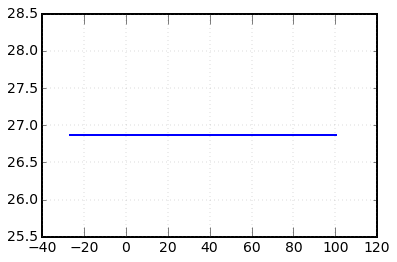

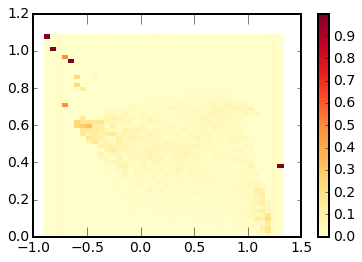

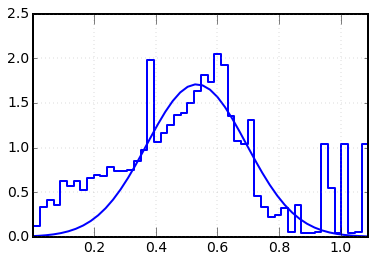

In [146]:
# Let's rotate this
rotation_angle = np.arctan(1.)

# Rotating the line
y_data = yvalues
x_data = xaxis_line
xpp = x_data*np.cos(rotation_angle) - y_data*np.sin(rotation_angle)
ypp = x_data*np.sin(rotation_angle) + y_data*np.cos(rotation_angle)
#plt.plot(x_data, y_data)
plt.plot(xpp,ypp)

# Rotating my function
plt.figure()
delta = (data['theta_f']-data['theta_i'])[sel]
new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)
new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)

xaxis = np.linspace(new_x.min(), new_x.max(), 41)
yaxis = np.linspace(new_y.min(), new_y.max(), 51)
n, x1, x2 = np.histogram2d(new_x, new_y, [xaxis, yaxis])
n2 = renormN(n,axis=1)
plt.pcolor(xaxis, yaxis, n2.T)
plt.colorbar()

plt.figure()
fit_y = np.sum(n2, axis=0)
jplot.unfilledBar(yaxis, fit_y)

fit_x = (yaxis[:-1]+yaxis[1:])/2.
fit_fcn = gaus
popt, pcov = optimize.curve_fit(gaus, fit_x[fit_x>0.35], 
                                fit_y[fit_x>0.35], p0=[100, 0.5, 0.3])

xtest = np.linspace(-1, 1.4, 100)
plt.plot(xtest, gaus(xtest, *popt))


print "The distribution has been rotated (delta Theta and theta in are the inputs)"
print "The rotation is given by"
print "new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)"
print "new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)"
print "The rotation angle is", rotation_angle
print "\nThe rotated distribution is a gaussian described by"
print "Mean", popt[1], "Sigma", popt[2]
print "Draw a random value from that distribution. That is new_y"
print "delta = ( new_y - theta_i*np.sin(rotation_angle) ) / np.cos(rotation_angle)"

Attempt of defining a gaussian as function of theta_i and not rotating
The gaussian structure is equally complicated


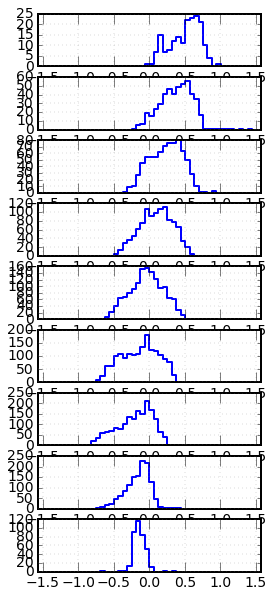

In [147]:
nbins= 9
fig = plt.figure(figsize=(4,10))
x2 = np.linspace(-np.pi/2, np.pi/2., 51)
theta_range = np.linspace(0, np.deg2rad(70), nbins+1)
for i in range(nbins):
    mybool = (data['theta_i'] > theta_range[i])*\
             (data['theta_i'] < theta_range[i+1])
 
    n, x2 = np.histogram(data['theta_f'][sel*mybool] - data['theta_i'][sel*mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)

print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

### The phi angle for single reflections

It is very simple and specular-like. Need to shift by 180deg to get the gaussian
Paramters of the distribution
Gauss height 0.0375417985272 mean 3.13902014818 sigma 0.515831548754 constant 0.0122743853759
Fraction going to the constant 0.61607548742


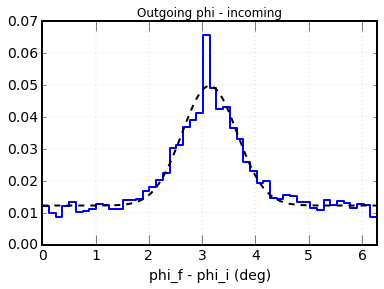

In [148]:
print 'It is very simple and specular-like. Need to shift by 180deg to get the gaussian'

shifted_phidiff = data['phidiff'] - np.pi
shifted_phidiff[shifted_phidiff<0] += 2*np.pi

x = np.linspace(0, np.pi*2, 51)
n, x= np.histogram(shifted_phidiff[sel],x)
n = n*1./np.sum(n)
jplot.unfilledBar(x,n)


xfit = edgesToMiddle(x)
newx = np.linspace(0, np.pi*2, 101)
fcn = lambda x, a, b, c, d: gaus(x,a,b, c) + d
popt, pcov = optimize.curve_fit(fcn, xfit, n, p0 = [0.1, np.pi, 1., 0.2])
curve = fcn(newx, *popt)
plt.plot(newx, curve, '--k')

#plt.xlabel('Incoming phi (deg)')
plt.xlabel('phi_f - phi_i (deg)')
#plt.colorbar()
plt.title('Outgoing phi - incoming')
print 'Paramters of the distribution'
print 'Gauss height', popt[0], 'mean', popt[1], 'sigma',popt[2], 'constant', popt[3]
print 'Fraction going to the constant', popt[3]*len(newx)/np.sum(curve)


### Theta angle for MULTIPLE reflections

In [22]:
print 'Selecting only the events that hit the PMT and leave after multiple reflections'
sel=( np.array([True]*len(data['y']))
     *pmt_hits
     *(data['nsteps'] > 1)
     #*(data['z'] > 0)
     #*(data['r']>0)
    )

Selecting only the events that hit the PMT and leave after multiple reflections


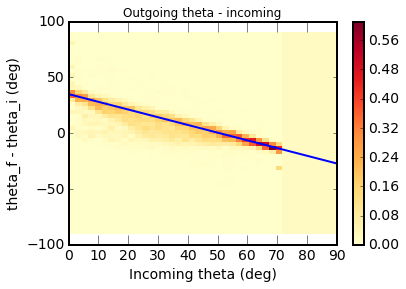

In [23]:
x1 = np.linspace(0, np.pi/2., 41)
x2 = np.linspace(-np.pi/2, np.pi/2., 51)
n, x1, x2 = np.histogram2d(data['theta_i'][sel], 
                           data['theta_f'][sel] - data['theta_i'][sel], 
                           [x1,x2])
n = renormN(n,axis=1)
plt.pcolor(np.rad2deg(x1),
           np.rad2deg(x2),
           n.T)
plt.xlabel('Incoming theta (deg)')
plt.ylabel('theta_f - theta_i (deg)')
plt.colorbar()
plt.title('Outgoing theta - incoming')
#plt.yticks(np.arange(-90, 90, 5.0))

xaxis_line = np.linspace(0, 90, 201)
yvalues = line_fcn(xaxis_line, -40./58, 35)
plt.plot(xaxis_line, yvalues)

The distribution has been rotated (delta Theta and theta in are the inputs)
The rotation is given by
new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)
new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)
The rotation angle is 0.603749333397

The rotated distribution is a gaussian described by
Mean 0.507316041851 Sigma 0.0612802912934
Draw a random value from that distribution. That is new_y
delta = ( new_y - theta_i*np.sin(rotation_angle) ) / np.cos(rotation_angle)


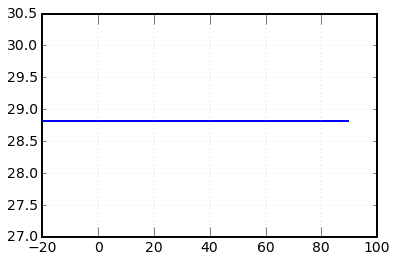

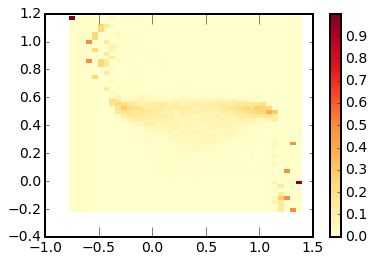

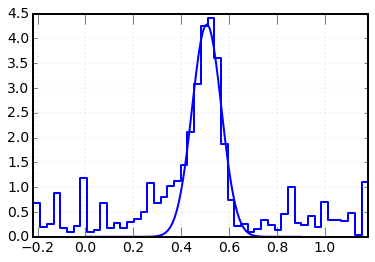

In [24]:
# Let's rotate this
rotation_angle = np.arctan(40./58.)

# Rotating the line
y_data = yvalues
x_data = xaxis_line
xpp = x_data*np.cos(rotation_angle) - y_data*np.sin(rotation_angle)
ypp = x_data*np.sin(rotation_angle) + y_data*np.cos(rotation_angle)
#plt.plot(x_data, y_data)
plt.plot(xpp,ypp)

# Rotating my function
plt.figure()
delta = (data['theta_f']-data['theta_i'])[sel]
new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)
new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)

xaxis = np.linspace(new_x.min(), new_x.max(), 41)
yaxis = np.linspace(new_y.min(), new_y.max(), 51)
n, x1, x2 = np.histogram2d(new_x, new_y, [xaxis, yaxis])
n2 = renormN(n,axis=1)
plt.pcolor(xaxis, yaxis, n2.T)
plt.colorbar()

plt.figure()
fit_y = np.sum(n2, axis=0)
jplot.unfilledBar(yaxis, fit_y)

fit_x = (yaxis[:-1]+yaxis[1:])/2.
fit_fcn = gaus
popt, pcov = optimize.curve_fit(gaus, fit_x[fit_x>0.35], 
                                fit_y[fit_x>0.35], p0=[100, 0.5, 0.3])

xtest = np.linspace(0, 0.9, 100)
plt.plot(xtest, gaus(xtest, *popt))


print "The distribution has been rotated (delta Theta and theta in are the inputs)"
print "The rotation is given by"
print "new_x = data['theta_i'][sel]*np.cos(rotation_angle) - delta*np.sin(rotation_angle)"
print "new_y = data['theta_i'][sel]*np.sin(rotation_angle) + delta*np.cos(rotation_angle)"
print "The rotation angle is", rotation_angle
print "\nThe rotated distribution is a gaussian described by"
print "Mean", popt[1], "Sigma", popt[2]
print "Draw a random value from that distribution. That is new_y"
print "delta = ( new_y - theta_i*np.sin(rotation_angle) ) / np.cos(rotation_angle)"

### Phi angle for MULTIPLE reflections

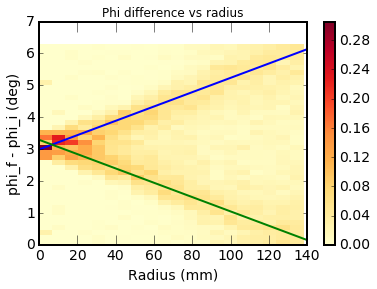

In [25]:
x1 = np.linspace(0, 138., 21)
x2 = np.linspace(0, np.pi*2, 41)
n, x1, x2 = np.histogram2d(data['r'][sel], 
                           data['phidiff'][sel], 
                           [x1,x2])
n = renormN(n,axis=1)
plt.pcolor(x1,
           x2,
           n.T)
plt.xlabel('Radius (mm)')
plt.ylabel('phi_f - phi_i (deg)')
plt.colorbar()
plt.title('Phi difference vs radius')

xaxis_line = np.linspace(0, 140, 201)
yvalues = line_fcn(xaxis_line, np.pi/140, np.pi-0.15)
yvalues2 = line_fcn(xaxis_line, -np.pi/140, np.pi+0.15)

plt.plot(xaxis_line, yvalues)
plt.plot(xaxis_line, yvalues2)

Simply get the gaussian from the beginning. Shift the other values
[ 25.89474121   3.17751496   0.33143682]
[ 52.30684558   3.12372632   0.48526586]
[ 27.87221277   3.18302597   0.81008931  24.74840396   3.13771335
   0.80981427]
[ 61.06191555   4.0340082    0.41167624  58.6255239    2.29350692
   0.48075983]
[ 54.10568895   4.36895314   0.57228186  52.96138817   1.9381392
   0.63910495]
[ 46.07549723   4.71527974   0.76584813  49.05554885   1.50618022
   0.67717992]
[ 46.45159544   5.21276939   0.82546033  42.67795756   1.10374077
   1.00409515]
[  4.94021242e+01   6.04822297e+00   1.40174311e+00   4.69770857e+01
  -6.55598441e-03   1.53708146e+00]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

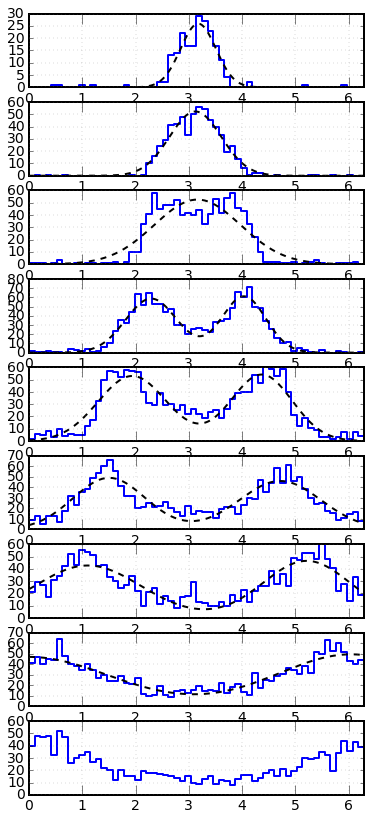

In [26]:
print 'Simply get the gaussian from the beginning. Shift the other values'
nbins= 9
fig = plt.figure(figsize=(6,14))
x2 = np.linspace(0, np.pi*2., 61)
xtest = np.linspace(0, np.pi*2, 201)

xfit = edgesToMiddle(x2)

means = np.zeros([nbins,2])
stds  = np.zeros([nbins,2])

radius_range = np.linspace(0, 140, nbins+1)
radius_fit   = edgesToMiddle(radius_range)
for i in range(nbins):
    mybool = (data['r'] > radius_range[i])*\
             (data['r'] < radius_range[i+1])
 
    n, x2 = np.histogram(data['phidiff'][sel*mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)
    
    p0a = [30, np.pi+i/2., 1.]
    p0b = [20, np.pi-i/2., 1.]
    
    if i <2:
        popt, pcov = optimize.curve_fit(gaus, xfit, n, p0 = p0a)
        plt.plot(xtest, gaus(xtest, *popt), '--k')
        means[i,:] = [popt[1], popt[1]]
        stds[i,:]  = [popt[2], popt[2]]
    else:
        popt, pcov = optimize.curve_fit(two_gaus, xfit, n, p0 = p0a+p0b)
        plt.plot(xtest, two_gaus(xtest, *popt), '--k')
        means[i,:] = [popt[1], popt[1+3]]
        stds[i,:]  = [popt[2], popt[2+3]]

    print popt

print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

Do not use the last point because the fit is missing.
Function for the mean  
0.02798 x + 2.5
Function for the std  
0.007659 x + 0.2465


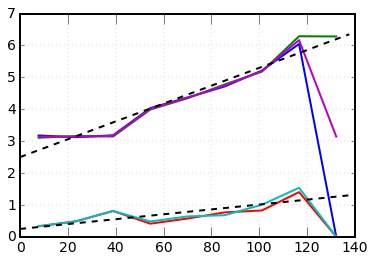

In [27]:
plt.plot(radius_fit, means[:,0])
plt.plot(radius_fit, 2*np.pi-means[:,1])
plt.plot(radius_fit, stds)

the_mean = ((means[:,0] + 2*np.pi-means[:,1])/2.)
plt.plot(radius_fit, the_mean)

print 'Do not use the last point because the fit is missing.'
mean_coeffs = np.polyfit(radius_fit[:-1], the_mean[:-1], deg=1)
std_coeffs  = np.polyfit(radius_fit[:-1], np.average(stds[:-1,:],axis=1), deg=1)

mean_fcn = np.poly1d(mean_coeffs)
std_fcn  = np.poly1d(std_coeffs)

xtest = np.linspace(0, greydisc_radius, 201)
plt.plot(xtest, mean_fcn(xtest), '--k')
plt.plot(xtest, std_fcn(xtest), '--k')

print 'Function for the mean', mean_fcn
print 'Function for the std', std_fcn

Lets rotate this thing


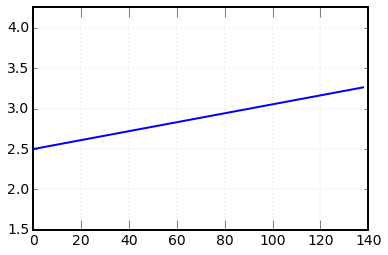

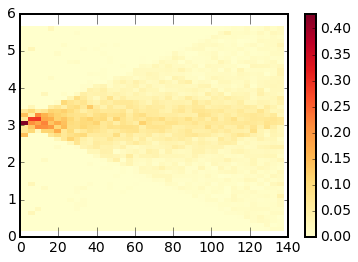

In [28]:
print 'Lets rotate this thing'
# Let's rotate this
rotation_angle = np.arctan(-0.02244)

# Rotating the line
x_data = xtest
y_data = mean_fcn(xtest)
xpp = x_data*np.cos(rotation_angle) - y_data*np.sin(rotation_angle)
ypp = x_data*np.sin(rotation_angle) + y_data*np.cos(rotation_angle)
#plt.plot(x_data, y_data)
plt.plot(xpp,ypp)
plt.ylim(ypp.min()-1., ypp.max()+1)

# Rotating my function
plt.figure()


# Splitting up and down here
up = data['phidiff'] > np.pi
down = data['phidiff'] < np.pi


new_x = data['r'][sel*up]*np.cos(rotation_angle) - data['phidiff'][sel*up]*np.sin(rotation_angle)
new_y = data['r'][sel*up]*np.sin(rotation_angle) + data['phidiff'][sel*up]*np.cos(rotation_angle)

new_xd = data['r'][sel*down]*np.cos(-rotation_angle) - data['phidiff'][sel*down]*np.sin(-rotation_angle)
new_yd = data['r'][sel*down]*np.sin(-rotation_angle) + data['phidiff'][sel*down]*np.cos(-rotation_angle)

all_x = np.concatenate((new_x, new_xd))
all_y = np.concatenate((new_y, new_yd))

xaxis = np.linspace(new_x.min(), new_x.max(), 41)
yaxis = np.linspace(new_y.min(), new_y.max(), 51)
n, x1, x2 = np.histogram2d(all_x, all_y, [xaxis, yaxis])
n2 = renormN(n,axis=1)
plt.pcolor(xaxis, yaxis, n2.T)
plt.colorbar()


Simply get the gaussian from the beginning. Shift the other values
[ 46.79364116   3.11515115   0.18111003]
[ 72.83684687   3.11484475   0.35190885]
[ 82.99611095   3.14028758   0.49788383]
[ 91.04804238   3.1418945    0.59266989]
[ 94.31020393   3.13023061   0.67332304]
[ 90.09429956   3.12631137   0.72864903]
[ 96.27613037   3.14291094  -0.68676755]
[ 96.07698702   3.12108655   0.63956298]
[ 51.35005472   3.21282263   1.05101183]
Attempt of defining a gaussian as function of theta_i and not rotating
The gaussian structure is equally complicated


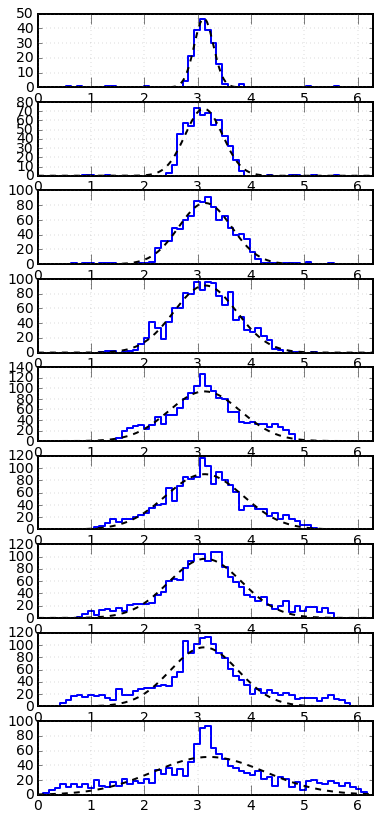

In [29]:
print 'Simply get the gaussian from the beginning. Shift the other values'
nbins= 9
fig = plt.figure(figsize=(6,14))
x2 = np.linspace(0, np.pi*2., 61)
xtest = np.linspace(0, np.pi*2, 201)

xfit = edgesToMiddle(x2)

means = np.zeros(nbins)
stds  = np.zeros(nbins)

radius_range = np.linspace(0, 140, nbins+1)
radius_fit   = edgesToMiddle(radius_range)
for i in range(nbins):
    mybool = (all_x > radius_range[i])*\
             (all_x < radius_range[i+1])
 
    n, x2 = np.histogram(all_y[mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)
    
    p0a = [30, np.pi+i/2., 1.]
    p0b = [20, np.pi-i/2., 1.]
    
    popt, pcov = optimize.curve_fit(gaus, xfit, n, p0 = p0a)
    plt.plot(xtest, gaus(xtest, *popt), '--k')
    means[i] = popt[1]
    stds[i]  = popt[2]


    print popt

print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

Function  
0.005203 x + 0.2361


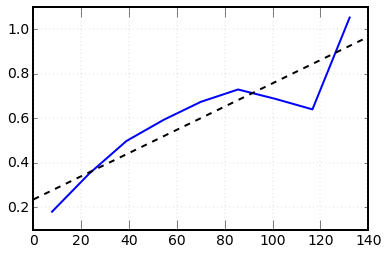

In [30]:
plt.plot(radius_fit, np.abs(stds))
xtest = np.linspace(0, greydisc_radius, 201)

fcn = np.poly1d(np.polyfit(radius_fit, np.abs(stds), deg=1))
plt.plot(xtest, fcn(xtest), '--k')
print 'Function', fcn

In [31]:
print 'Steps\n'

print "Get the radius R - so close to actual radius, no need to rotate"
print 'Determine the STD DEV of the gaussian to use with 0.00897*r + 0.1378'
print "Evaluate a random gauss, multiply times STD DEV"
print "Draw another random number to determine rotation up or down (50/50)"
print "Get the phidiff mean by:"
print "(+/-)0.02244 *r + 2.777"
print "Sum that number to the random number drawn before"
print "Verify you can rotate by so much"

Steps

Get the radius R - so close to actual radius, no need to rotate
Determine the STD DEV of the gaussian to use with 0.00897*r + 0.1378
Evaluate a random gauss, multiply times STD DEV
Draw another random number to determine rotation up or down (50/50)
Get the phidiff mean by:
(+/-)0.02244 *r + 2.777
Sum that number to the random number drawn before
Verify you can rotate by so much


# Hit the CONCENTRATOR first

In [32]:
print 'Selecting only the events that hit the CONCENTRATOR'
sel=( np.array([True]*len(data['y']))
     *conc_hits
     
    )
print 'Events ', np.sum(sel)


Selecting only the events that hit the CONCENTRATOR
Events  186905


Define single/multiple reflections
This function is enough. Draw random number, eval the function at theta_i
If random is larger than fcn value, single rejection
         5         4          3          2
-0.8421 x + 1.596 x - 0.3076 x - 0.9682 x + 0.5958 x + 0.7952


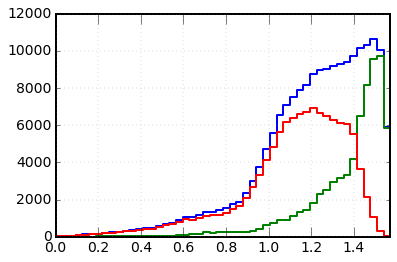

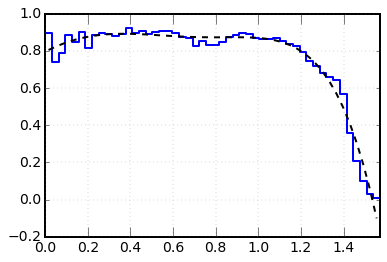

In [33]:
print 'Define single/multiple reflections'
xaxis = np.linspace(0, np.pi/2., 51)
yvalues = data['theta_i'][sel]
n, x = np.histogram(yvalues, xaxis)
jplot.unfilledBar(x,n)
yvalues = data['theta_i'][sel*(data['nsteps']<1.5)]
ns, x = np.histogram(yvalues, xaxis)
jplot.unfilledBar(x,ns, color = 'green')
yvalues = data['theta_i'][sel*(data['nsteps']>1.5)]
nm, x = np.histogram(yvalues, xaxis)
jplot.unfilledBar(x,nm, color = 'red')


xfit = edgesToMiddle(xaxis)
fcn  = np.poly1d(np.polyfit(xfit, nm*1./n, deg=5))

plt.figure()
jplot.unfilledBar(x, nm*1./n)
plt.plot(xfit, fcn(xfit), '--k')

print 'This function is enough. Draw random number, eval the function at theta_i'
print 'If random is larger than fcn value, single rejection'
print fcn

## Theta for either SINGLE or MULTIPLE is specular<br> For multiple it has a width. For single is perfectly specular.

[  1.02158019e+04  -2.53478355e-02   8.41849368e-02]
[  2.05134824e+04  -4.92786534e-03  -6.50858958e-02]
Using the same standard deviation for both of 0.08 radians


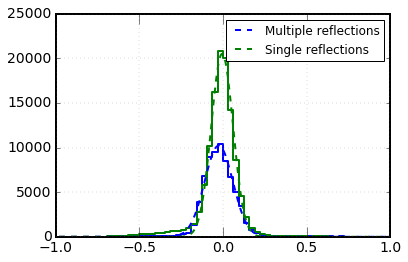

In [34]:
xaxis = np.linspace(-np.pi/2. , np.pi/2, 101)
ydata = data['theta_f'] - data['theta_i']
single = data['nsteps'] < 1.5
multiple = data['nsteps'] > 1.5

xfit = edgesToMiddle(xaxis)
xtst = np.linspace(xaxis.min(), xaxis.max(), 500)

n, x = np.histogram(ydata[sel*single], xaxis)
jplot.unfilledBar(x,n)

n2, x = np.histogram(ydata[sel*multiple], xaxis)
jplot.unfilledBar(x, n2, color = 'green')

popt, pcov = optimize.curve_fit(gaus, xfit, n, p0 = [8000, 0., 0.3])
popt2, pcov = optimize.curve_fit(gaus, xfit, n2, p0 = [3000, 0., 0.3])

plt.plot(xtst, gaus(xtst, *popt), '--b', label='Multiple reflections')
plt.plot(xtst, gaus(xtst, *popt2), '--g', label='Single reflections')
plt.xlim(-1,1)
print popt
print popt2
plt.legend(loc=0)
print 'Using the same standard deviation for both of 0.08 radians'

## PHI for single reflections

In [35]:
print 'Selecting only the events that hit the CONCENTRATOR'
sel=( np.array([True]*len(data['y']))
     *conc_hits
     *(data['nsteps'] < 1.5)
     
    )
print 'Events ', np.sum(sel)


Selecting only the events that hit the CONCENTRATOR
Events  70669


[ 163.57836205    3.14425032   -0.27285236]
[  4.42885294e+02   3.12910669e+00   3.29632696e-01]
[  3.44364567e+02   2.79269393e+00   2.78242429e-01   4.27948707e+02
   3.40359619e+00   3.32053675e-01]
[ 323.25429003    3.14369882    0.62571368  203.89353982    3.14305436
    0.62574315]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

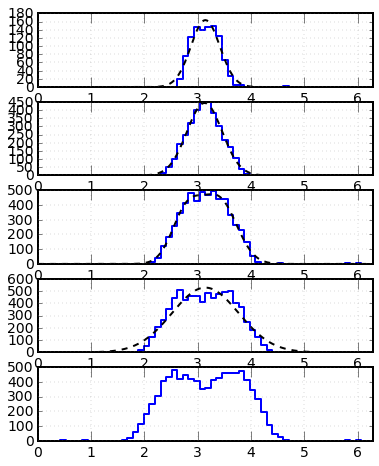

In [36]:
nbins= 9
fig = plt.figure(figsize=(6,14))
x2 = np.linspace(0, np.pi*2., 61)
xtest = np.linspace(0, np.pi*2, 201)

xfit = edgesToMiddle(x2)

means = np.zeros([nbins,2])
stds  = np.zeros([nbins,2])

radius_range = np.linspace(0, 130., nbins+1)
radius_fit   = edgesToMiddle(radius_range)
for i in range(nbins):
    mybool = (data['r'] > radius_range[i])*\
             (data['r'] < radius_range[i+1])
 
    n, x2 = np.histogram(data['phidiff'][sel*mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)
    
    p0a = [30, np.pi+i/5., 1.]
    p0b = [20, np.pi-i/5., 1.]
    
    if i <2:
        popt, pcov = optimize.curve_fit(gaus, xfit, n, p0 = p0a)
        plt.plot(xtest, gaus(xtest, *popt), '--k')
        means[i,:] = [popt[1], popt[1]]
        stds[i,:]  = [popt[2], popt[2]]
    else:
        popt, pcov = optimize.curve_fit(two_gaus, xfit, n, p0 = p0a+p0b)
        plt.plot(xtest, two_gaus(xtest, *popt), '--k')
        means[i,:] = [popt[1], popt[1+3]]
        stds[i,:]  = [popt[2], popt[2+3]]

    print popt
    
stds = np.abs(stds)

print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

Do not use the last point because the fit is missing.
Function for the mean  
0.000755 x + 3.06
Function for the std  
-0.001054 x + 0.1844


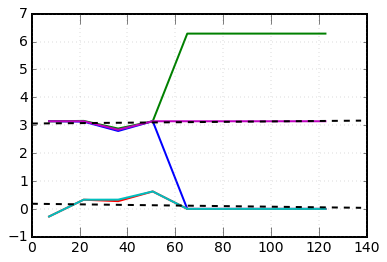

In [37]:
plt.plot(radius_fit, means[:,0])
plt.plot(radius_fit, 2*np.pi-means[:,1])
plt.plot(radius_fit, stds)

the_mean = ((means[:,0] + 2*np.pi-means[:,1])/2.)
plt.plot(radius_fit, the_mean)

print 'Do not use the last point because the fit is missing.'
mean_coeffs = np.polyfit(radius_fit[:-1], the_mean[:-1], deg=1)
std_coeffs  = np.polyfit(radius_fit[:-1], np.average(stds[:-1,:],axis=1), deg=1)

mean_fcn = np.poly1d(mean_coeffs)
std_fcn  = np.poly1d(std_coeffs)

xtest = np.linspace(0, greydisc_radius, 201)
plt.plot(xtest, mean_fcn(xtest), '--k')
plt.plot(xtest, std_fcn(xtest), '--k')

print 'Function for the mean', mean_fcn
print 'Function for the std', std_fcn

Lets rotate this thing


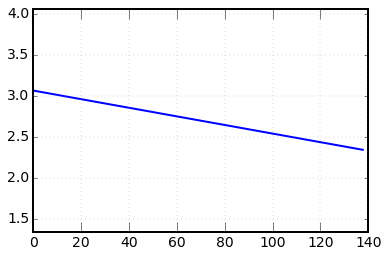

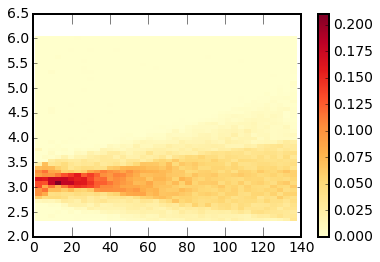

In [38]:
print 'Lets rotate this thing'
# Let's rotate this
rotation_angle = np.arctan(0.005997*-1.)

# Rotating the line
x_data = xtest
y_data = mean_fcn(xtest)
xpp = x_data*np.cos(rotation_angle) - y_data*np.sin(rotation_angle)
ypp = x_data*np.sin(rotation_angle) + y_data*np.cos(rotation_angle)
#plt.plot(x_data, y_data)
plt.plot(xpp,ypp)
plt.ylim(ypp.min()-1., ypp.max()+1)

# Rotating my function
plt.figure()


# Splitting up and down here
up = data['phidiff'] > np.pi
down = data['phidiff'] < np.pi


new_x = data['r'][sel*up]*np.cos(rotation_angle) - data['phidiff'][sel*up]*np.sin(rotation_angle)
new_y = data['r'][sel*up]*np.sin(rotation_angle) + data['phidiff'][sel*up]*np.cos(rotation_angle)

new_xd = data['r'][sel*down]*np.cos(-rotation_angle) - data['phidiff'][sel*down]*np.sin(-rotation_angle)
new_yd = data['r'][sel*down]*np.sin(-rotation_angle) + data['phidiff'][sel*down]*np.cos(-rotation_angle)

all_x = np.concatenate((new_x, new_xd))
all_y = np.concatenate((new_y, new_yd))

xaxis = np.linspace(new_x.min(), new_x.max(), 41)
yaxis = np.linspace(new_y.min(), new_y.max(), 51)
n, x1, x2 = np.histogram2d(all_x, all_y, [xaxis, yaxis])
n2 = renormN(n,axis=1)
plt.pcolor(xaxis, yaxis, n2.T)
plt.colorbar()


Simply get the gaussian from the beginning. Shift the other values
[  2.56640024e+02   3.14442572e+00   1.92749320e-01]
[  8.96198483e+02   3.13890902e+00   1.73952472e-01]
[  1.06854252e+03   3.14112803e+00  -2.43790334e-01]
[  1.06697110e+03   3.13445721e+00  -3.29718564e-01]
[  1.00440018e+03   3.14693091e+00   4.09140689e-01]
[  9.30642793e+02   3.14027257e+00   4.85843808e-01]
[  8.51125969e+02   3.13878612e+00   5.51516333e-01]
[  7.62132617e+02   3.13576008e+00   5.83607032e-01]
[ 508.54508053    3.13687347    0.55506258]
Attempt of defining a gaussian as function of theta_i and not rotating
The gaussian structure is equally complicated


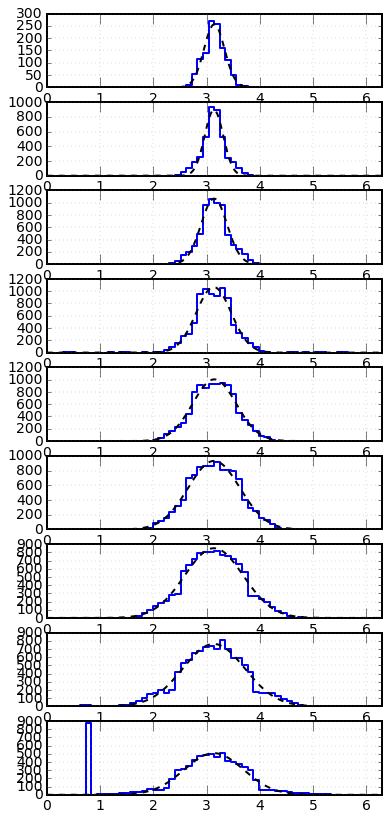

In [39]:
print 'Simply get the gaussian from the beginning. Shift the other values'
nbins= 9
fig = plt.figure(figsize=(6,14))
x2 = np.linspace(0, np.pi*2., 61)
xtest = np.linspace(0, np.pi*2, 201)

xfit = edgesToMiddle(x2)

means = np.zeros(nbins)
stds  = np.zeros(nbins)

radius_range = np.linspace(0, 140, nbins+1)
radius_fit   = edgesToMiddle(radius_range)
for i in range(nbins):
    mybool = (all_x > radius_range[i])*\
             (all_x < radius_range[i+1])
 
    n, x2 = np.histogram(all_y[mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)
    
    p0a = [30, np.pi+i/2., 1.]
    p0b = [20, np.pi-i/2., 1.]
    
    popt, pcov = optimize.curve_fit(gaus, xfit, n, p0 = p0a)
    plt.plot(xtest, gaus(xtest, *popt), '--k')
    means[i] = popt[1]
    stds[i]  = popt[2]


    print popt

print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

Function  
0.003696 x + 0.133


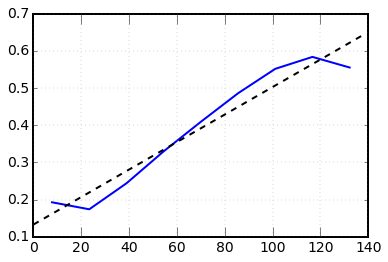

In [40]:
plt.plot(radius_fit, np.abs(stds))
xtest = np.linspace(0, greydisc_radius, 201)

fcn = np.poly1d(np.polyfit(radius_fit, np.abs(stds), deg=1))
plt.plot(xtest, fcn(xtest), '--k')
print 'Function', fcn

## PHI for MULTIPLE reflections

In [41]:
print 'Selecting only the events that hit the CONCENTRATOR'
sel=( np.array([True]*len(data['y']))
     *conc_hits
     *(data['nsteps'] > 1.5)
     
    )
print 'Events ', np.sum(sel)


Selecting only the events that hit the CONCENTRATOR
Events  116236


Attempt of defining a gaussian as function of theta_i and not rotating
The gaussian structure is equally complicated


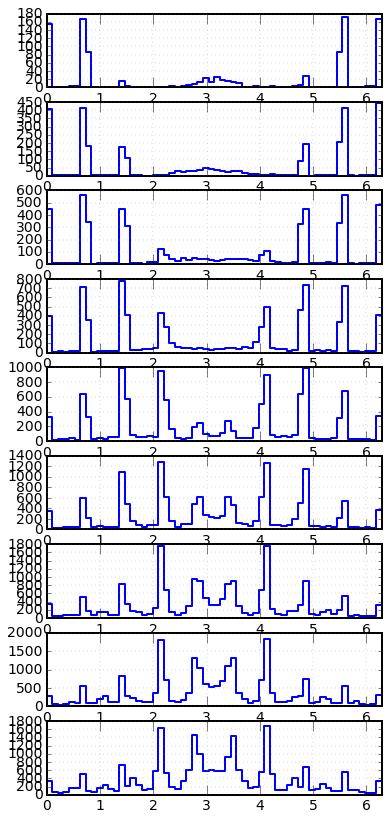

In [44]:
nbins= 9
fig = plt.figure(figsize=(6,14))
x2 = np.linspace(0, np.pi*2., 61)
xtest = np.linspace(0, np.pi*2, 201)

xfit = edgesToMiddle(x2)

means = np.zeros([nbins,2])
stds  = np.zeros([nbins,2])

radius_range = np.linspace(0, 130., nbins+1)
radius_fit   = edgesToMiddle(radius_range)
for i in range(nbins):
    mybool = (data['r'] > radius_range[i])*\
             (data['r'] < radius_range[i+1])
 
    n, x2 = np.histogram(data['phidiff'][sel*mybool], 
                         x2)
    #np.sum(n)
    fig.add_subplot(nbins,1,i+1)
    
    jplot.unfilledBar(x2,n)
    


print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

In [225]:
print 'For now I will just put 9 peaks for this function. No more.'

For now I will just put 9 peaks for this function. No more.


In [62]:
np.rad2deg(x2)

array([ -2.00000000e+01,  -1.83333333e+01,  -1.66666667e+01,
        -1.50000000e+01,  -1.33333333e+01,  -1.16666667e+01,
        -1.00000000e+01,  -8.33333333e+00,  -6.66666667e+00,
        -5.00000000e+00,  -3.33333333e+00,  -1.66666667e+00,
        -3.18055468e-15,   1.66666667e+00,   3.33333333e+00,
         5.00000000e+00,   6.66666667e+00,   8.33333333e+00,
         1.00000000e+01,   1.16666667e+01,   1.33333333e+01,
         1.50000000e+01,   1.66666667e+01,   1.83333333e+01,
         2.00000000e+01,   2.16666667e+01,   2.33333333e+01,
         2.50000000e+01,   2.66666667e+01,   2.83333333e+01,
         3.00000000e+01,   3.16666667e+01,   3.33333333e+01,
         3.50000000e+01,   3.66666667e+01,   3.83333333e+01,
         4.00000000e+01,   4.16666667e+01,   4.33333333e+01,
         4.50000000e+01,   4.66666667e+01,   4.83333333e+01,
         5.00000000e+01,   5.16666667e+01,   5.33333333e+01,
         5.50000000e+01,   5.66666667e+01,   5.83333333e+01,
         6.00000000e+01,

40 (400,)


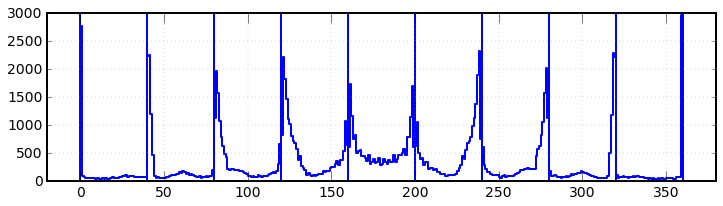

In [114]:
nbins= 9
fig = plt.figure(figsize=(12,3))
#x2 = np.arange(np.deg2rad(-20), np.pi*2.+np.deg2rad(20),np.deg2rad(1))
x2 = np.linspace(np.deg2rad(-20), np.pi*2.+np.deg2rad(20), 401)
xtest = np.linspace(0, np.pi*2, 201)

#print np.sum(x2<np.deg2rad(20.)), x2.shape
rollover = np.sum(x2<np.deg2rad(20.))-1
#print rollover, x2.shape

xfit = edgesToMiddle(x2)

means = np.zeros([nbins,2])
stds  = np.zeros([nbins,2])

radius_range = np.linspace(0, 130., nbins+1)
radius_fit   = edgesToMiddle(radius_range)
n, x2 = np.histogram(data['phidiff'][sel], 
                         x2)
print rollover, n.shape

for i in range(10):
    plt.axvline(i*40., ymax=5000.)

    #np.sum(n)
#fig.add_subplot(nbins,1,i+1)
    
jplot.unfilledBar(np.rad2deg(x2),n)


(10, 40)
[  8.38238058e+03  -1.21397382e-04   4.79194655e-02   1.46367866e+03]
Attempt of defining a gaussian as function of theta_i and not rotating
The gaussian structure is equally complicated


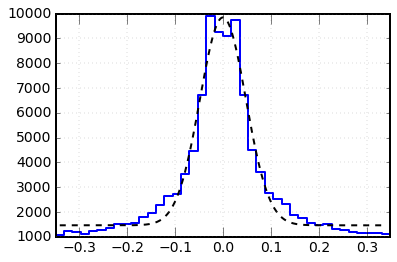

In [124]:

plt.figure()
nfixed = n.reshape([n.size/rollover,rollover])
print nfixed.shape

newy = np.sum(nfixed,axis=0)
newx = x2[:rollover+1]

jplot.unfilledBar(newx, newy)


xfit = edgesToMiddle(newx)

fcn = lambda x, a, b, c, d: gaus(x,a,b, c) + d

popt, pcov = optimize.curve_fit(fcn, xfit, newy, p0=[8000,0., 0.2, 1000.])
xtest = np.linspace(xfit.min(), xfit.max(), 1000.)
plt.plot(xtest, fcn(xtest, *popt), '--k')

print popt
print 'Attempt of defining a gaussian as function of theta_i and not rotating'
print 'The gaussian structure is equally complicated'

In [126]:
np.rad2deg(0.05)

2.8647889756541165